# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_new import LuvoirAPLC

## Instantiate a simple SM for mode plotting

I need to simplify this... I can make a child class like I did for the full LUVOIR simulator.

In [2]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

## Mode and eigenvalue units

Since the matrices got generated normalized to an aberration of 1 nm, everything stemming from the matrix will be in units of **nanometers**. --> This is the desired behaviour of course and is yet to be confirmed, which is one of the goals of this notebook.

In [3]:
eunit = 1e-9

## Also instantiate a LUVOR telescope

For cumulative contrast calculation.

> **ATTENTION:** the variable `apodizer_design` has to be correct for the data we are reading with the variable `savedpath` further below!!!

In [4]:
# pupil_diameter = 15.0 #m actual circumscribed diameter, used for lam/D calculations other measurements normalized by this diameter
# pupil_inscribed = 13.5 #m actual inscribed diameter
# actual_segment_flat_diameter = 1.2225 #m actual segment flat-to-flat diameter
# actual_segment_gap = 0.006 #m actual gap size between segments
# spider_width = 0.150 #m actual strut size
# lower_spider_angle = 12.7 #deg angle at which lower spiders are offset from vertical
# spid_start = 0.30657 #m spider starting point distance from center of aperture
# gap_padding = 1
# segment_gap = actual_segment_gap * gap_padding  
# segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
# segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter
# # Scaling the positions for LUVOIR segments
# segment = hc.hexagonal_aperture(segment_circum_diameter, np.pi / 2)
# segment_sampled = hc.evaluate_supersampled(segment, pupil_grid, 1)
# seg_pos = seg_pos.scaled(pupil_diameter)
# aper2, segs2 = hc.make_segmented_aperture(segment,seg_pos, segment_transmissions=1, return_segments= True)
# luvoir_segmented_pattern = hc.evaluate_supersampled(aper2, pupil_grid, 1)
# seg_evaluated = []
# for seg_tmp in segs2:
#     tmp_evaluated = hc.evaluate_supersampled(seg_tmp, pupil_grid, 1)
#     seg_evaluated.append(tmp_evaluated)
# plt.figure(figsize=(10, 10))
# hc.imshow_field(luvoir_segmented_pattern)

In [5]:
# # Creating a modal basis with zernikes on each segment 
# Nzernike = 3
# seg_num = 0
# mode_basis_local_zernike = hc.mode_basis.make_zernike_basis(Nzernike, segment_circum_diameter, pupil_grid.shifted(-seg_pos[seg_num]), starting_mode=1,
#                                  ansi=False, radial_cutoff=True, use_cache=True)
# for qq in range(0,Nzernike):
#      mode_basis_local_zernike._transformation_matrix[:,qq] = seg_evaluated[seg_num]*mode_basis_local_zernike._transformation_matrix[:,qq]
# for seg_num in range(1,120):
#     print(seg_num)
#     mode_basis_local_zernike_tmp = hc.mode_basis.make_zernike_basis(Nzernike, segment_circum_diameter, pupil_grid.shifted(-seg_pos[seg_num]), starting_mode=1,
#                                  ansi=False, radial_cutoff=True, use_cache=True)
#     for qq in range(0,Nzernike):
#         mode_basis_local_zernike_tmp._transformation_matrix[:,qq] = seg_evaluated[seg_num]*mode_basis_local_zernike_tmp._transformation_matrix[:,qq]
#     mode_basis_local_zernike.extend(mode_basis_global_zernike_tmp)
# global_zernike_aberrations = hc.optics.DeformableMirror(mode_basis_global_zernike)
# zernike_coeffs = np.zeros([mode_basis_global_zernike.num_modes])
# zernike_order = 99
# zernike_coeffs[zernike_order] = 0.0001*wvln
# global_zernike_aberrations.actuators = zernike_coeffs
# zernike_aberrations = global_zernike_aberrations(wf_aper)
# plt.figure(figsize=(10, 10))
# hc.imshow_field(zernike_aberrations.phase)
# plt.figure(figsize=(10, 10))
# hc.imshow_field(seg_evaluated[seg_num])

In [6]:
# Instantiate LUVOIR
sampling = 4
apodizer_design = 'large'
# This path is specific to the paths used in the LuvoirAPLC class
optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'

luvoir = LuvoirAPLC(optics_input, apodizer_design, sampling)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [7]:
from config import CONFIG_INI

In [8]:
# System parameters
coro_design = CONFIG_INI.get('LUVOIR', 'coronagraph_size')
design = coro_design
overall_dir = util.create_data_path(CONFIG_INI.get('local', 'local_data_path'), telescope = 'luvoir-'+design)
os.makedirs(overall_dir, exist_ok=True)
resDir = os.path.join(overall_dir, 'matrix_numerical')
max_zern_number = CONFIG_INI.getint('calibration', 'maxzernike')

# General telescope parameters
nb_seg = CONFIG_INI.getint('LUVOIR', 'nb_subapertures')
wvln = CONFIG_INI.getfloat('LUVOIR', 'lambda') * 1e-9  # m
diam = CONFIG_INI.getfloat('LUVOIR', 'diameter')  # m
nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration') * 1e-9   # m

# Image system parameters
im_lamD = CONFIG_INI.getfloat('numerical', 'im_size_lamD_hcipy')  # image size in lambda/D
sampling = CONFIG_INI.getfloat('numerical', 'sampling')

# Print some of the defined parameters
print('LUVOIR apodizer design: {}'.format(design))
print()
print('Wavelength: {} m'.format(wvln))
print('Telescope diameter: {} m'.format(diam))
print('Number of segments: {}'.format(nb_seg))
print()
print('Image size: {} lambda/D'.format(im_lamD))
print('Sampling: {} px per lambda/D'.format(sampling))

# Create necessary directories if they don't exist yet
os.makedirs(resDir, exist_ok=True)
os.makedirs(os.path.join(resDir, 'OTE_images'), exist_ok=True)
os.makedirs(os.path.join(resDir, 'psfs'), exist_ok=True)

#  Copy configfile to resulting matrix directory
util.copy_config(resDir)

### Instantiate Luvoir telescope with chosen apodizer design
optics_input = CONFIG_INI.get('LUVOIR', 'optics_path')
luvoir = LuvoirAPLC(optics_input, design, sampling)

/Users/pueyo/Documents/data_from_repos/pastis_data

LUVOIR apodizer design: medium

Wavelength: 6.380000000000001e-07 m
Telescope diameter: 15.0 m
Number of segments: 120

Image size: 30.0 lambda/D
Sampling: 4.0 px per lambda/D
Saving the configfile to outputs folder.


FileNotFoundError: [Errno 2] No such file or directory: 'config.ini'

In [9]:
luvoirMat = LuvoirAPLC(optics_input, design, sampling)

In [10]:
luvoirMat.make_segment_zernike_primary(1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


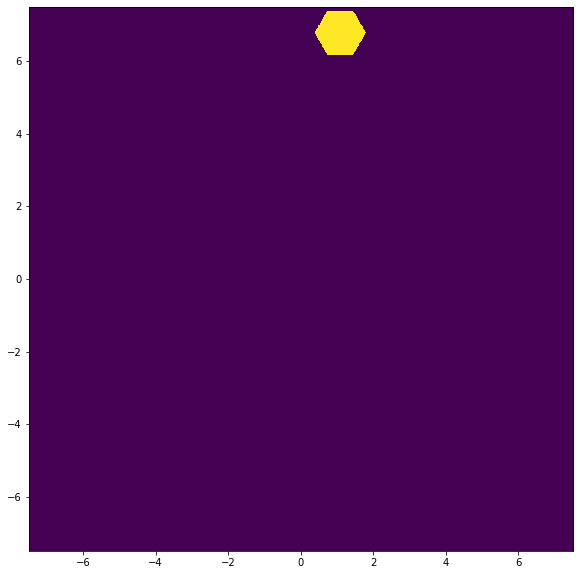

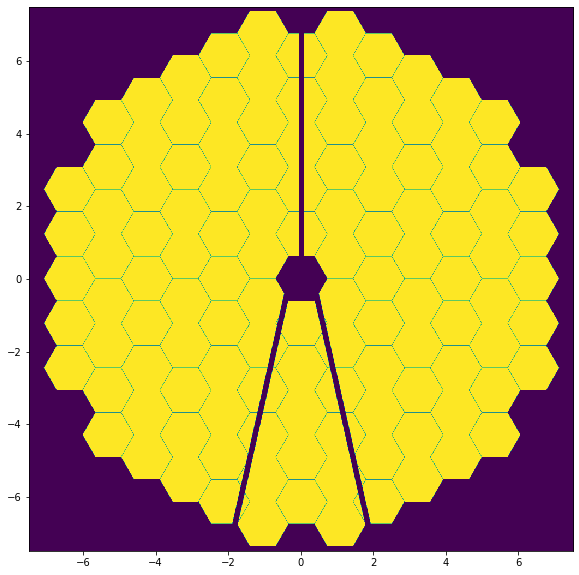

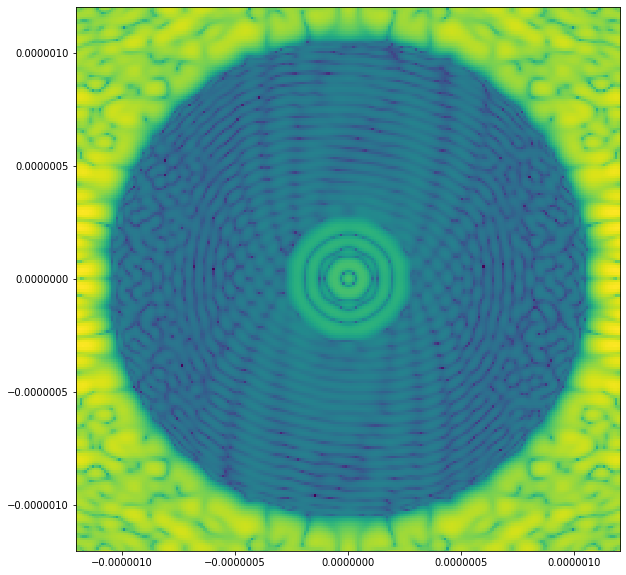

In [23]:
zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
zernike_order = 99
zernike_coeffs[zernike_order] = 0.001*wvln
luvoirMat.sm.actuators = zernike_coeffs
zernike_aberrations = luvoirMat.sm(luvoirMat.wf_aper)
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_aberrations.phase)
plt.figure(figsize=(10, 10))
hc.imshow_field(zernike_aberrations.amplitude)
psf_unaber, ref = luvoirMat.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber, norm=LogNorm())

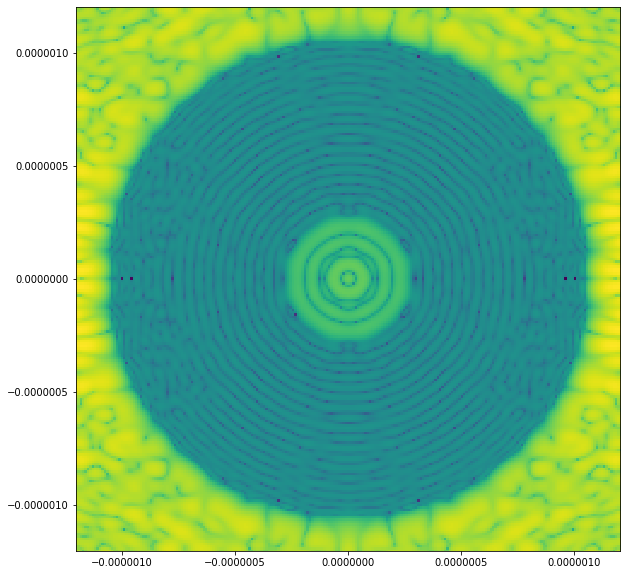

In [24]:
# Make reference image
# luvoir.flatten()
zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
luvoirMat.sm.actuators = zernike_coeffs
luvoirMat.sm(luvoirMat.wf_aper)
psf_unaber, ref = luvoirMat.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber, norm=LogNorm())

In [25]:
### Dark hole mask
dh_outer = hc.circular_aperture(2 * luvoirMat.apod_dict[design]['owa'] * luvoirMat.lam_over_d)(luvoirMat.focal_det)
dh_inner = hc.circular_aperture(2 * luvoirMat.apod_dict[design]['iwa'] * luvoirMat.lam_over_d)(luvoirMat.focal_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

### Reference images for contrast normalization and coronagraph floor
unaberrated_coro_psf, ref = luvoirMat.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)

dh_intensity = (unaberrated_coro_psf / norm) * dh_mask
contrast_floor = np.mean(dh_intensity[np.where(dh_mask != 0)])
print('contrast floor: {}'.format(contrast_floor))

contrast floor: 3.924822663883738e-11


In [26]:
# zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
# luvoirMat.sm.actuators = zernike_coeffs
# luvoirMat.sm(luvoirMat.wf_aper)
# norm = np.max(ref)

In [15]:
# zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
# zernike_coeffs[pp] =  nm_aber/2
# luvoirMat.sm.actuators = zernike_coeffs
# luvoirMat.sm(luvoirMat.wf_aper)
# aberrated_coro_psf, ref, inter = luvoirMat.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
# focus_field1 = inter['at_science_focus']
# zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
# zernike_coeffs[qq] =  nm_aber/2
# luvoirMat.sm.actuators = zernike_coeffs
# luvoirMat.sm(luvoirMat.wf_aper)
# aberrated_coro_psf, ref, inter = luvoirMat.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
# focus_field2 = inter['at_science_focus']
# zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
# zernike_coeffs[pp] =  nm_aber/2
# zernike_coeffs[qq] =  nm_aber/2
# luvoirMat.sm.actuators = zernike_coeffs
# luvoirMat.sm(luvoirMat.wf_aper)
# aberrated_coro_psf, ref, inter = luvoirMat.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
# intensity_cross = aberrated_coro_psf
# delta_poke_all = aberrated_coro_psf.intensity
# plt.figure(figsize=(10, 10))
# hc.imshow_field(delta_poke_all,norm=LogNorm())

|C[poke1+poke2+base]|^2
|base|^2 + |poke1|^2 + |poke2|^2 + 2*Re(poke2 base*) + 2*Re(poke1 base*) + 2*Re(poke1 poke2*)
|base|^2 + |poke1|^2 + 2*Re(poke1 base*) 
|base|^2 + |poke2|^2 + 2*Re(poke2 base*) 
|base|^2 + |poke1|^2 + |poke1|^2 + 4*Re(poke1 base*)+ 2*|poke1|^2 = |C[poke1+poke1+base]|^2
|poke1|^2 + |poke2|^2 + 2*Re(poke2 base*) + 2*Re(poke1 base*) + 2*Re(poke1 poke2*) - (4*|poke1|^2 + 4*Re(poke1 base*)) )

In [16]:
Efield_ref = inter_ref['at_science_focus'].electric_field
# Efield1 = focus_field1.electric_field
# Efield2 = focus_field2.electric_field
# delta_Efield1 = Efield1- Efield_ref
# delta_Efield2 = Efield2- Efield_ref
# cross_int = np.real(delta_Efield1*np.conjugate(delta_Efield2))
# plt.figure(figsize=(10, 10))
# hc.imshow_field(cross_int)

In [61]:
Number_of_modes = luvoirMat.sm.num_actuators
focus_fieldS = []

for pp in range(0,Number_of_modes):
    print(pp)
    zernike_coeffs = np.zeros([luvoirMat.sm.num_actuators])
    zernike_coeffs[pp] =  nm_aber/2
    luvoirMat.sm.actuators = zernike_coeffs
    luvoirMat.sm(luvoirMat.wf_aper)
    aberrated_coro_psf, ref, inter = luvoirMat.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
    focus_field1 = inter['at_science_focus'] 
    focus_fieldS.append(focus_field1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [34]:
# i = 1
# j = 3
# test = 2*np.real(focus_fieldS[i].electric_field*np.conj(focus_fieldS[j].electric_field))
# dh_test = test * dh_mask
# contrast = np.mean(dh_test[np.where(dh_mask != 0)])

In [62]:
mat_fast = np.zeros([Number_of_modes,Number_of_modes])
for i in range(0,Number_of_modes):
    for j in range(0,Number_of_modes):
        test = np.real((focus_fieldS[i].electric_field-Efield_ref)*np.conj(focus_fieldS[j].electric_field-Efield_ref))
        dh_test = test * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_fast[i,j] = contrast/norm

In [63]:
savedpath = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-05-07T10-55-02_luvoir-medium'   # large apodizer LUVOIR
savedpath2 = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-06-08T18-11-32_luvoir-medium'   # large apodizer LUVOIR

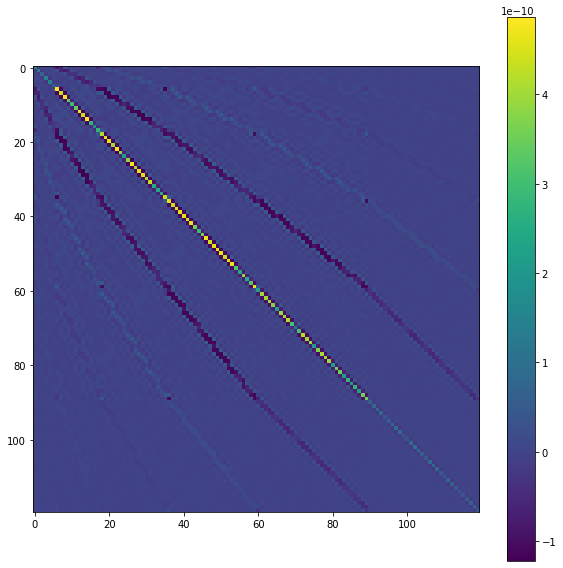

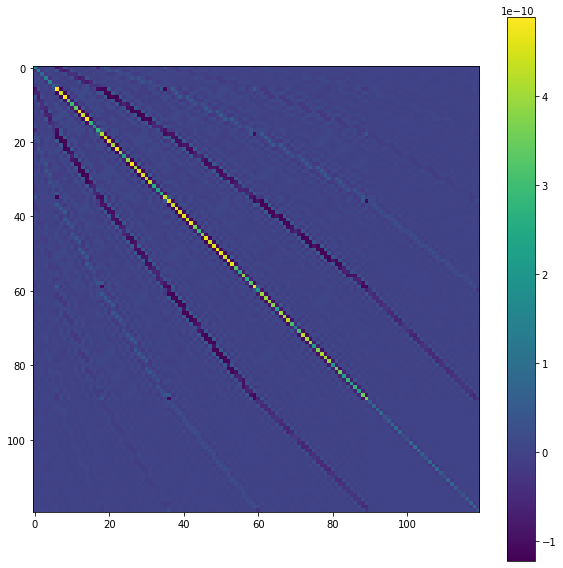

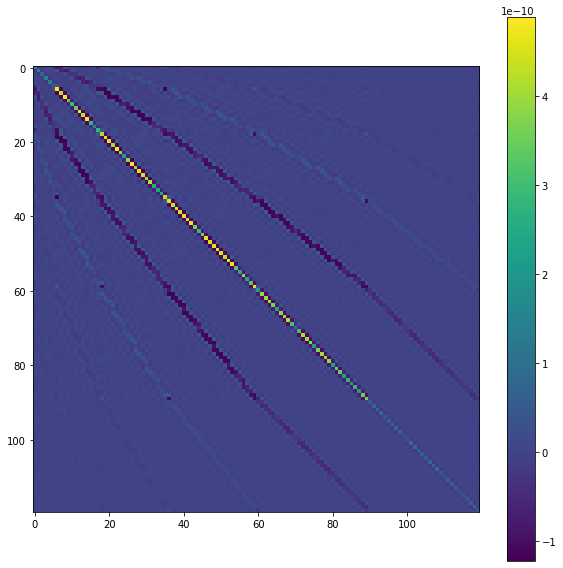

In [64]:
matrix = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'PASTISmatrix_num_piston_Noll1.fits'))
matrix2 = fits.getdata(os.path.join(savedpath2, 'matrix_numerical', 'PASTISmatrix_num_Multiple_Modes_MaxZer_1.fits'))

plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.colorbar()

plt.figure(figsize=(10, 10))
plt.imshow(matrix2)
plt.colorbar()

plt.figure(figsize=(10, 10))
plt.imshow(mat_fast)
plt.colorbar()

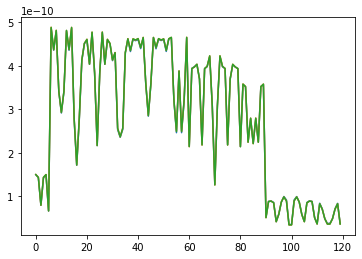

In [65]:
plt.plot(np.diag(matrix))
plt.plot(np.diag(matrix2))
plt.plot(np.diag(mat_fast))

In [68]:
np.diag(mat_fast)-np.diag(matrix)

array([ 2.91990604e-13,  9.79936661e-13,  1.39298728e-13,  1.03109146e-12,
        3.58441808e-13,  7.51188579e-13,  2.27526381e-12,  1.38619335e-12,
        1.40104165e-12,  7.12602575e-13,  1.41392411e-12,  1.00392002e-12,
        1.41948055e-12,  1.34798592e-12,  2.31169876e-12,  3.73706469e-12,
        6.86863318e-13,  3.39202610e-12,  1.41299599e-12,  6.02736551e-13,
        2.02898548e-12,  2.68422738e-13,  2.10784176e-12,  1.50765783e-12,
        1.78497566e-13,  1.63536568e-12,  1.92837504e-12,  3.13515065e-13,
        2.08530279e-12,  6.45286485e-13,  1.42819782e-12, -2.44088427e-14,
        3.08581213e-12,  1.22924905e-12,  2.93124695e-12,  1.62536381e-13,
        8.71418339e-13,  2.42950538e-12,  1.80157828e-12,  1.61106639e-12,
        2.45465000e-12,  2.26498896e-12,  6.89788567e-13,  1.15795161e-12,
        1.43287751e-12,  1.41645625e-12,  4.95338991e-13,  2.70042915e-12,
        1.90784526e-12,  1.38170185e-12,  1.23300945e-12,  2.17129013e-12,
        2.98827942e-13,  

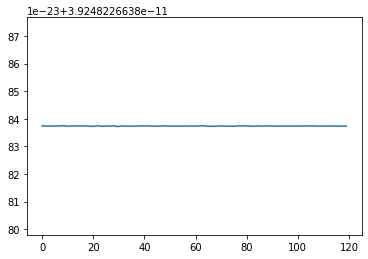

In [54]:
plt.plot(np.diag(mat_fast)-np.diag(matrix2) - )

In [31]:
np.median(np.abs((matrix-matrix2)/matrix2))

0.012717910540250652

In [32]:
np.median(np.abs((mat_fast-matrix2)/matrix2))

11.958676667257595

## Check matrix calculation with field. 

In [ ]:
zernike_coeffs = np.zeros([luvoir.sm.num_actuators])
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)

## Read eigenmodes and eigenvalues

In [ ]:
# Which directory are we working in?
savedpath = '/Users/ilaginja/Documents/data_from_repos/pastis_data/2019-8-07_002_1nm'    # small apodizer LUVOIR

# Load eigenvalues - lowest first, highest at the end
evals = np.loadtxt(os.path.join(savedpath, 'results', 'singular_values.txt'))
print('evals.shape: {}'.format(evals.shape))

# Load eigenmodes - piston value per segment per mode
emodes = np.loadtxt(os.path.join(savedpath, 'results', 'singular_modes.txt'))
print('emodes.shape: {}'.format(emodes.shape))

# Load eigenmodes (just for plotting) - mode images
epics = hc.read_fits(os.path.join(savedpath, 'results', 'modes', 'fits', 'cube_modes.fits'))
print('emodes.shape: {}'.format(epics.shape))

Check that eigenmodes are in correct order and how to address them in the data cube.

In [ ]:
mode = 2   # We start numbering at 0 here, 0-35 (Python nunmbering!)

sm.flatten()
for seg, val in enumerate(emodes[:, mode]):
    #print(val)
    sm.set_segment(seg+1, eunit*val/2, 0, 0)

# Propagate WF and display SM phase
wf_sm = sm(wf_aper)

hc.imshow_field(wf_sm.phase, cmap='RdBu')
plt.colorbar()

In [ ]:
# Show the values per segment of a specific mode and its rms
modenr = 2
print(emodes[:, modenr])
print(np.std(emodes[:, modenr]))
print(np.mean(emodes[:, modenr]))

print(np.std(np.array([0, 1, 1])))
print(np.sqrt((0**2 - (2/3)**2 + 1**2 - (2/3)**2 + 1**2 - (2/3)**2)/3))   # this is the std calculation by hand

So we have `emodes[segments, modes]`.

## Stability requirements

### Static contrast and static contribution

According to Lucie's paper, we can get the maximum aberration $\sigma_p$ we can allow per mode $p$ if we want to obtain a contrast $C$ directly from the according eigenvalue $\lambda_p$.

$$\sigma_p = \sqrt{\frac{C_p}{\lambda_p}}$$

Where $C_p$ is the contrast contribution from mode $p$ only. For simplicity, we assume that all modes have the same contribution to the total contrast $C$, meaning

$$C = C_1 + C_2 + ... + C_N$$

with $N$ being the total number of modes. This also means

$$C_p = \frac{C}{N}$$

Since we have one mode that has a really low eigenvalue and essentially on contribution, we can take that mode out and assume that the other $N-1$ modes bear all the contrast contributions, changing it to

$$C_p = C_1 + C_2 + ... + C_{N-1}$$

and

$$C_p = \frac{C}{N-1}$$

So we can calculate the maximum ocntribution of a mode $\sigma_p$ with

$$\sigma_p = \sqrt{\frac{C}{(N-1)\lambda_p}}$$

We have 120 segments, so $N=120$ and we will aim to achieve a static contrast of $C = 10^{-10}$.

Note how we start numbering at 1 here, to stay consistent with our segment numbering, but when doing these things in Python we need to start numbering at 0.

Skype with Lucie, have to include baseline contrast $C_0$:

$$\sigma_p = \sqrt{\frac{C-C_0}{(N-1)\lambda_p}}$$

In [ ]:
c_stat = 1e-10
print('Static contrast: {}'.format(c_stat))
print('N = {}'.format(nseg))

In [ ]:
# Calculate single sigma - remember that we start numbering at 0 because of python
def get_sigma(cstat, nseg, eigenval, c_zero):
    sigma = np.sqrt((cstat - c_zero) / ((nseg-1)*eigenval))
    return sigma

In [ ]:
p = 1
sigma_p = get_sigma(c_stat, nseg, evals[p], baseline_contrast)
print(sigma_p)

In [ ]:
# Do them all at once
sigmas = get_sigma(c_stat, nseg, evals, baseline_contrast)
print(sigmas)

# Save them
#np.savetxt(os.path.join(savedpath, 'results', 'sigmas.txt'), sigmas)

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(sigmas[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

### Dynamic contast and dynamic contribution

We want $\Delta C = 10^{-11}$. This "dynamic contast" is the error on the contrast $C$ which we want to limit, so we write it as

$$\Delta C = \sqrt{\Delta C_1^2 + \Delta C_2^2 + ... \Delta C_N^2} = \sqrt{N \Delta C_p^2} = \sqrt{N} \Delta C_p$$

which also means

$$\Delta C_p = \frac{C}{\sqrt{N}}$$

and then again because we discard that non-contributing mode, we actually have

$$\Delta C_p = \frac{C}{\sqrt{N-1}}$$

For the $\Delta \sigma_p$ we can use the same equation like for the $\sigma_p$, but we plug in $\Delta C$ instead of $C$.

$$\Delta \sigma_p = \sqrt{\frac{\Delta C}{\lambda_p}} = \sqrt{\frac{\Delta C}{\sqrt{(N-1)}\ \lambda_p}}$$

In [ ]:
c_dyn = 1e-11

# Calculate the Delta Cs
def get_delta_sigma(cdyn, nseg, eigenval):
    del_sigma = np.sqrt(cdyn / (np.sqrt(nseg-1)*eigenval))
    return del_sigma

In [ ]:
del_sigmas = get_delta_sigma(c_dyn, nseg, evals)
print(del_sigmas)

# Save them
#np.savetxt(os.path.join(savedpath, 'results', 'delta_sigmas.txt'), del_sigmas)

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(del_sigmas[1:])
plt.semilogy()
plt.title('Stability per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\Delta \sigma_p$ (nm)', size=15)

These are only slightly larger than the $\sigma_p$.

### Cumulative contrast plot

I guess the only way I can think of right now to verify at least the $\sigma_p$ is to make the same cumulative contrast like Fig. 11b in Lucie's paper. Let's do that.

Since I never get rid of the first mode, global piston with a ridiculously low eigenvalue, I will have a `Nan` in the sigma array, so when I sum up the OPD, I have to use `numpy.nansum()` instead of `numpy.nan()`.

#### Cumulative contrast with E2E simulator

In [ ]:
cont_cum_e2e = []
for maxmode in range(len(evals)):

    opd = np.nansum(emodes[:, :maxmode+1]*sigmas[:maxmode+1], axis=1)

    luvoir.flatten()
    for seg, val in enumerate(opd):
        luvoir.set_segment(seg+1, eunit*val/2, 0, 0)
        
    # Get PSF from putting this OPD on the SM
    psf = luvoir.calc_psf()

    # Calculate the contrast from that PSF
    dh_intensity = psf/norm * dh_mask
    contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
    cont_cum_e2e.append(contrast)

In [ ]:
# Save cumulative contrast plot from E2E simulator
#np.savetxt(os.path.join(savedpath, 'results', 'cumulative_contrast_e2e.txt'), cont_cum_e2e)

In [ ]:
# Plot the cumulative contrast from E2E simulator
plt.figure(figsize=(16, 10))
plt.plot(cont_cum_e2e)
plt.title('E2E cumulative contrast for target $C$ = ' + str(c_stat), size=15)
plt.xlabel('Mode number', size=15)
plt.ylabel('Constrast', size=15)

#plt.savefig(os.path.join(savedpath, 'results', 'cumulative_contrast_e2e.pdf'))

In [ ]:
# Look at the images up to including the mode with number 'modenr'
modenr = 1

# Trying to different sigmas
sigfix1 = sigmas[:modenr+1]*1
sigfix2 = 0

opd1 = np.nansum(emodes[:, :modenr+1]*sigfix1, axis=1)
luvoir.flatten()
for seg, val in enumerate(opd1):
    luvoir.set_segment(seg+1, eunit*val/2, 0, 0)
psf1 = luvoir.calc_psf()

opd2 = np.nansum(emodes[:, :modenr+1]*sigfix2, axis=1)
luvoir.flatten()
for seg, val in enumerate(opd2):
    luvoir.set_segment(seg+1, eunit*val/2, 0, 0)
psf2 = luvoir.calc_psf()

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
hc.imshow_field(np.log10(psf1), vmin=2, vmax=12)
plt.colorbar()
plt.subplot(1, 2, 2)
hc.imshow_field(np.log10(psf2), vmin=2, vmax=12)
plt.colorbar()

contast folowing mode amplitude quadratically? Fig. 12 in Lucie
bigger contribution with higher target contrast?
rerun with slightly maller FPM (by 0.5 lambda/D); more leakage

In [ ]:
# Show the image difference
hc.imshow_field(np.log10(psf2-psf1), vmin=2, vmax=12)
plt.colorbar()

#### Cumulative cotrast with numerical PASTIS matrix

In [ ]:
# Read matrix
matrix = fits.getdata(os.path.join(savedpath, 'matrix_numerical/PASTISmatrix_num_piston_Noll1.fits'))

# Calculate cumulative contrast
cont_cum_pastis = []
for maxmode in range(len(evals)):
    aber = np.nansum(emodes[:, :maxmode+1]*sigmas[:maxmode+1], axis=1)
    aber *= u.nm
    
    contrast_matrix = util.pastis_contrast(aber, matrix) + baseline_contrast
    cont_cum_pastis.append(contrast_matrix)

In [ ]:
# Save cumulative contrast plot from numerical PASTIS matrix
#np.savetxt(os.path.join(savedpath, 'results', 'cumulative_contrast_pastis.txt'), cont_cum_pastis)

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(cont_cum_pastis, label='PASTIS matrix')
plt.plot(cont_cum_e2e, label='E2E')
plt.title('Cumulative contrast for target $C$ = ' + str(c_stat), size=15)
plt.xlabel('Mode number', size=15)
plt.ylabel('Constrast', size=15)
plt.legend()

#plt.savefig(os.path.join(savedpath, 'results', 'cumulative_contrast_pastis.pdf'))

Difference between this plot when matrix PASTIS and when E2E simulator - why?

Sweeeeeet!!! :D I realized today that I have been using the medium apodizer design all along, but then remembered that form the three LUVOIR APLC designs, only the small one had a good accordance of its contrast calculation with the matrix compared with the E2E simulation - the medium and large designs still have a constant offset that I haven't figured out. So when I reverted back to using the small design, this essentially fell out of the sky haha.

## Checking normalisation

$M$ is a mode and $p,q$ go from 1 to 120. The modes are normalized when their dot product is 1 for a mode with itself and 0 in all other cases:

$$<M_p, M_q>_{pup} = \begin{cases} \mbox{0} & p \neq q \\ \mbox{1} & p = q \end{cases}$$

The image plane modes $\mathscr{C}(M_p)$ (= a pupil plane mode $M$ propagated through the coronagraph) should be orthogonal and the diagonal of this matrix filled with the eigenvaues $\Lambda_p$:

$$<\mathscr{C}(M_p), \mathscr{C}(M_q)>_{DH} = \begin{cases} \mbox{0} & p \neq q \\ \Lambda_p & p = q \end{cases}$$

### Check orthonormality for pupil modes $M_p$

In [ ]:
# Try this for a random pair of modes
modedot1 = 1
modedot2 = 1

res = np.dot(emodes[:, modedot1], emodes[:, modedot2])
print(res)

In [ ]:
# Do this for all modes
pupildot = np.zeros((120, 120))

for dotrun in range(len(evals)):
    for dotforrest in range(len(evals)):
        
        pupildot[dotrun, dotforrest] = np.dot(emodes[:, dotrun], emodes[:, dotforrest])

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(pupildot)

In [ ]:
print('Sum of entire matrix: {}'.format(np.sum(pupildot)))
ab = 34
cd = 92
print('Off-axis element ({},{}): {}'.format(ab, cd, pupildot[ab, cd]))
on = 72
print('On-axis element ({},{}): {}'.format(on, on, pupildot[on, on]))

The pupil modes are orthonormal when using the PASTIS matrix.

How about the full pupil images?

In [ ]:
# Load the pupil modes
pupil_modes = fits.getdata(os.path.join(savedpath, 'results', 'modes', 'fits', 'cube_modes.fits'))
print('Shape: {}'.format(pupil_modes.shape))

In [ ]:
# This takes a little while
haha = np.zeros((120, 120))
for dotrun in range(len(evals)):
    for dotforrest in range(len(evals)):
        
        haha[dotrun, dotforrest] = np.vdot(pupil_modes[dotrun], pupil_modes[dotforrest])

In [ ]:
print(haha.shape)
print(haha)
# Divide by numbers in each segment?
plt.figure(figsize=(10, 10))
plt.imshow(haha)
plt.title('Pupil plane orthogonality')
plt.colorbar()

In [ ]:
print('Sum of entire matrix: {}'.format(np.sum(haha)))
ab = 34
cd = 92
print('Off-axis element ({},{}): {}'.format(ab, cd, haha[ab, cd]))
on = 72
print('On-axis element ({},{}): {}'.format(on, on, haha[on, on]))

I might have to divide by the number of pixels in each segment or something like that in order to actually get the ones and zeros. But the shown matrix clearly confirms that they're at least orthogonal.

In [ ]:
# Display one loaded pupil mode
plt.imshow(pupil_modes[25])
plt.colorbar()
# Not sure what the colorbar is here

In [ ]:
# Not sure what I am doing here, trying to reproduce something Laurent did I think
pup_area = np.where(pupil_modes[0] != 0)   # this doesn't actually make a difference
def normpastis(mode):
    norm = np.sqrt(np.sum(mode[pup_area]**2))
    return norm

print(normpastis(pupil_modes[1]))

### Create or read image modes $\mathscr{C}(M_p)$

In [ ]:
# Create them
all_psfs = []
all_efields = []

for gump in range(len(evals)):
    print('Working on mode {}/{}'.format(gump+1, len(evals)))
    luvoir.flatten()
    for seg, val in enumerate(emodes[:, gump]):
        luvoir.set_segment(seg+1, eunit*val/2, 0, 0)
    psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
    # Everything gets returns as an E-field here, the coro PSF, the no-FPM reference and the intermediate planes.
    # Except for the intensity image right after the FPM.
    
    # Save as fits
    #hc.write_fits(psf, os.path.join(savedpath, 'results', 'modes', 'image_modes', 'mode'+str(gump+1)+'.fits'))
    
    all_psfs.append(psf)
    all_efields.append(inter)

In [ ]:
# Read them
# ...

In [ ]:
# Check the intermediates
print(type(all_efields))
print(type(all_efields[0]))
print(all_efields[0].keys())
print(type(all_efields[0]['after_lyot']))

In [ ]:
# Check one of the PSFs
print(len(all_psfs))
plt.figure(figsize=(10, 10))
hc.imshow_field(all_psfs[67].intensity/norm, norm=LogNorm())
plt.colorbar()

In [ ]:
# With DH mask
hc.imshow_field(all_psfs[67].intensity/norm * dh_mask, norm=LogNorm())
plt.colorbar()

In [ ]:
# Keep it in terms of E-field
print(type(all_psfs[0].electric_field))
print(all_psfs[0].electric_field.shape)
print(all_psfs[0].electric_field)

### Checking the orthogonality for image modes $\mathscr{C}(M_p)$

In [ ]:
# Try this for a random pair of modes
imdot1 = 50
imdot2 = 50

res = np.vdot((all_psfs[imdot1].intensity/norm * dh_mask), (all_psfs[imdot2].intensity/norm * dh_mask))
print(res)

In [ ]:
dhdh = np.zeros((120, 120))
mean_int = []
for dotrun in range(len(evals)):
    inten = all_psfs[dotrun].intensity/norm * dh_mask
    mean_int.append(np.mean(inten[np.where(inten != 0)]))
    
    for dotforrest in range(len(evals)):
        
        dhdh[dotrun, dotforrest] = np.vdot(all_psfs[dotrun].intensity/norm * dh_mask, all_psfs[dotforrest].intensity/norm * dh_mask)

In [ ]:
# Plot the mean contrast in the DH as function of mode
plt.plot(mean_int)
plt.semilogy()
plt.ylabel('Mean contrast in DH')
plt.xlabel('Mode number')

In [ ]:
print(dhdh.shape)
print(dhdh)
plt.figure(figsize=(10, 10))
plt.imshow(dhdh)
plt.title('Image plane orthogonality')
plt.colorbar()

## Segment based constraints

Instead of getting a maximum allowable aberration amplitud eper mode, we'll get them per segment now.

From Laurent:

$$\epsilon_{S_q} = \sum_{p} a_{p,q}^2\epsilon_p$$

I think in my world of variables this means ($P$ being the matrix holding the eigenmodes (eigenvectors), which is `emodes[segments, modes]`):

$$\mu_q = \sum_{p} P_{p,q}^2 \sigma_p$$

Remember: `emodes[segments, modes]`

In [ ]:
print(emodes.shape)
print(sigmas.shape)

mus = np.zeros_like(sigmas)
print(mus.shape)

# For one segment
segm = 3
test = emodes[segm,:]**2 * sigmas
print(np.nansum(test))

# For all segments
for i in range(len(sigmas)):
    mus[i] = np.nansum(emodes[i,:]**2 * sigmas)

In [ ]:
print('Units are nanometers')
print('Min: {}'.format(np.min(mus)))
print('Max: {}'.format(np.max(mus)))
print(mus)

In [ ]:
# Plot that
sm.flatten()
for seg, val in enumerate(mus):
    #print(val)
    sm.set_segment(seg+1, 1e-9*val/2, 0, 0)

# Propagate WF and display SM phase
wf_sm = sm(wf_aper)

plt.figure(figsize=(10, 10))
hc.imshow_field(wf_sm.phase / wf_sm.wavenumber, cmap='Blues')   # in meters
plt.colorbar()

### PDF of contrast for segment requirements $\mu$

#### With the E2E simulator

In [ ]:
# Create as many random numbers between 0 and 1 as we have segments
rand = np.random.random(nseg)
print(rand.shape)

In [ ]:
# Multiply each segment mu by one of these random numbers,
# put that on the LUVOIR SM and calculate the PSF.
# Be careful with units: the mus are in nanometers, the LUVOIR
# simulator needs it in meters though, plus in surface rather
# than in OPD (hence the division by 2)

luvoir.flatten()
for seg, (mu, randval) in enumerate(zip(mus, rand)):
    #print(seg, mu, randval)
    #luvoir.set_segment(seg+1, 6e-9*mu*randval/2, 0, 0)    # fudge factor of 6? maybe 2*pi?
    luvoir.set_segment(seg+1, 1e-9*mu/2, 0, 0)
psf = luvoir.calc_psf(display_intermediate=True)

In [ ]:
# Display the PSF next to the reference PSF
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
hc.imshow_field(psf/norm, norm=LogNorm())
plt.title('PSF with randomly strong $\mu$', size=15)
plt.colorbar()

plt.subplot(1, 2, 2)
hc.imshow_field(psf_unaber/norm, norm=LogNorm())
plt.title('Unaberrated PSF', size=15)
plt.colorbar()

In [ ]:
# Measure mean contrast
dh_rand = psf/norm * dh_mask
rand_contrast = np.mean(dh_rand[np.where(dh_rand != 0)])
print('contrast:', rand_contrast)

Now put all of this into an extra loop layer and repeat N times (N = 1000?)

In [ ]:
n_repeat = 100
#"""
all_contr_rand = []
for rep in range(n_repeat):
    print('Realization {}/{}'.format(rep+1, n_repeat))
    
    # Create as many random numbers between 0 and 1 as we have segments
    rand = np.random.random(nseg)
    
    # Multiply each segment mu by one of these random numbers,
    # put that on the LUVOIR SM and calculate the PSF.
    luvoir.flatten()
    for seg, (mu, randval) in enumerate(zip(mus, rand)):
        luvoir.set_segment(seg+1, 1e-9*mu*randval/2, 0, 0)
    psf, ref = luvoir.calc_psf(ref=True)
    
    # Measure mean contrast after removing coronagraph floor
    dh_rand = (psf/norm - psf_unaber/norm) * dh_mask
    rand_contrast = np.mean(dh_rand[np.where(dh_rand != 0)])
    all_contr_rand.append(rand_contrast)
    #print('Contrast:', rand_contrast)
#"""

In [ ]:
# Plot as histogram
plt.figure(figsize=(16, 10))
n, bins, patches = plt.hist(all_contr_rand, 100)
plt.title('E2E raw contrast', size=20)
plt.xlabel('Mean contrast in DH', size=20)
plt.ylabel('PDF', size=20)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=25)

#### With the matrix calculation

In [ ]:
# Create as many random numbers between 0 and 1 as we have segments
rand = np.random.normal(loc_mu, sigma, nseg)
print(rand.shape)

In [ ]:
# Multiply each segment mu by one of these random numbers
# and calculate the mean contrast with matrix PASTIS

# Read matrix
matrix = fits.getdata(os.path.join(savedpath, 'matrix_numerical/PASTISmatrix_num_piston_Noll1.fits'))

# Multiply all mus by a random number
aber = mus * rand * u.nm
print(aber.shape)
print(aber)

# Calculate contrast
contrast_matrix = util.pastis_contrast(aber, matrix) + baseline_contrast
print(contrast_matrix)
#cont_cum_pastis.append(contrast_matrix)

# not there yet

Add the outer loop and do this N times.

In [ ]:
n_repeat = 1000
#"""
all_contr_rand_ma = []
for rep in range(n_repeat):
    print('Realization {}/{}'.format(rep+1, n_repeat))
    
    # Create as many random numbers between 0 and 1 as we have segments
    rand = np.random.random(nseg)
    
    # Calculate mean contrast
    rand_contrast = util.pastis_contrast(mus*rand*u.nm, matrix)
    all_contr_rand_ma.append(rand_contrast)
    #print('Contrast:', rand_contrast)
#"""

In [ ]:
# Plot as histogram
plt.figure(figsize=(16, 10))
n, bins, patches = plt.hist(all_contr_rand_ma, 250)

In [22]:
1e7*1e5

1000000000000.0

In [23]:
1e4*10

100000.0